### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [47]:
import numpy as np
import itertools

import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from QPCA.decomposition.Qpca import QPCA
from qiskit.circuit.library.data_preparation.state_preparation import *
from QPCA.preprocessingUtilities.preprocessing_matrix_utilities import generate_matrix


In [37]:
example_matrix=generate_matrix(matrix_dimension=2,replicate_paper=False,seed=19)

Matrix:



<IPython.core.display.Math object>

eigenvalue: 0.04912229458049476 - eigenvector: [-0.233  0.973]
eigenvalue: 0.6199503657038241 - eigenvector: [0.973 0.233]


In [38]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.88034375, 0.19315908],
        [0.19315908, 0.11965625]]),
 (array([0.92658152, 0.07341848]),
  array([[ 0.9725247 , -0.23279972],
         [ 0.23279972,  0.9725247 ]])))

In [39]:
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

In [40]:
print(input_probabilities)

[0.89705523 0.04318619 0.04318619 0.0165724 ]


In [41]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [42]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

0 -> 0.9696604633240288
1 -> 0.24445569305342432
00 -> 0.9471299950763292
01 -> 0.20781286428054138
10 -> 0.20781286428054138
11 -> 0.1287338312400718


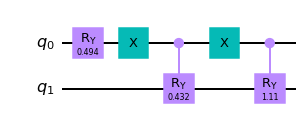

In [43]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw('mpl')

In [44]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.897055227573288,
 '01': 0.043186186560483,
 '10': 0.043186186560483,
 '11': 0.016572399305747}

In [45]:
#Unitary for PE
resolution = 3
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_22582/2942357963.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 8.95473769e-01-0.39686772j, -2.46828593e-17-0.20155084j],
          [-2.46828593e-17-0.20155084j,  8.95473769e-01+0.39686772j]],
         input_dims=(2,), output_dims=(2,))

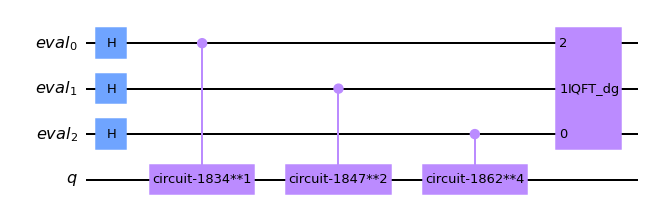

In [46]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

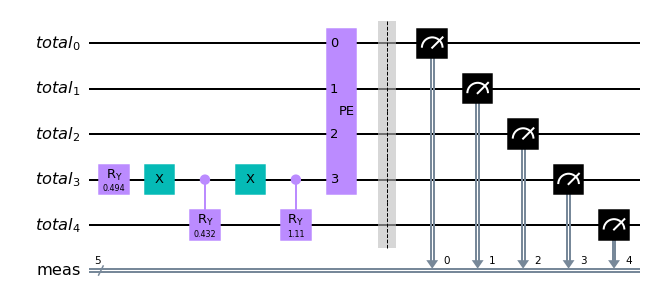

In [12]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim1 = QuantumRegister(tot_qubit, 'total')


total_circuit_sim1 = QuantumCircuit(qr_total_sim1, name='matrix')

total_circuit_sim1.append(matrix_circuit.to_gate(), qr_total_sim1[resolution:])
total_circuit_sim1.append(pe.to_gate(), qr_total_sim1[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
total_circuit_sim1.measure_all()

total_circuit_sim1.decompose(reps=1).draw("mpl")

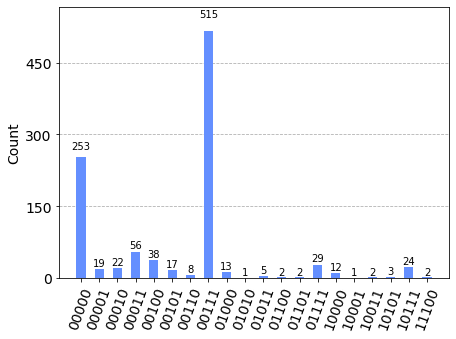

In [13]:
aer_back=Aer.get_backend('qasm_simulator')
st=aer_back.run(transpile(total_circuit_sim1,aer_back)).result().get_counts()
plot_histogram(st)

# Threshold example of paper

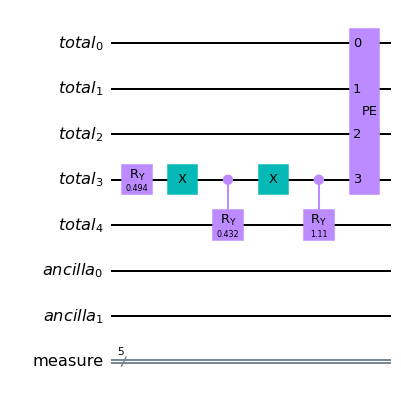

In [14]:
ancilla=2
ancilla_reg=QuantumRegister(ancilla,'ancilla')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(5, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim,ancilla_reg,classical, name='matrix')
display(total_circuit_sim)
total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

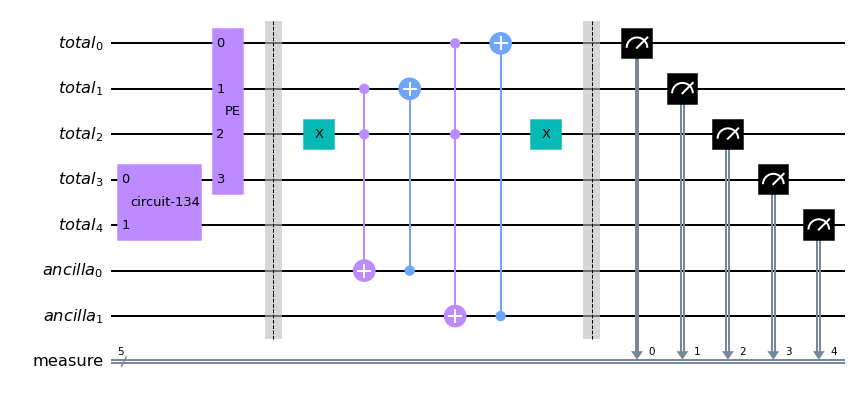

In [16]:
total_circuit_sim.barrier()
total_circuit_sim.x(2)
total_circuit_sim.ccx(1,2,ancilla_reg[0])
total_circuit_sim.cx(ancilla_reg[0],1)

total_circuit_sim.ccx(0,2,ancilla_reg[1])
total_circuit_sim.cx(ancilla_reg[1],0)
total_circuit_sim.x(2)
total_circuit_sim.barrier()
total_circuit_sim.measure([0,1,2,3,4],classical)
total_circuit_sim.draw('mpl')

In [17]:
#000,001,010,011
# Se togliamo il primo ccx/cx, tagliamo fuori 001 e 011 ma non 010.

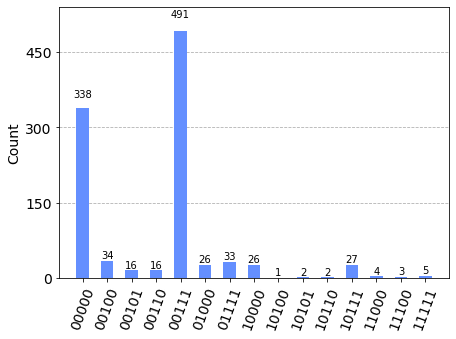

In [18]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim,aer)).result().get_counts()
plot_histogram(result)

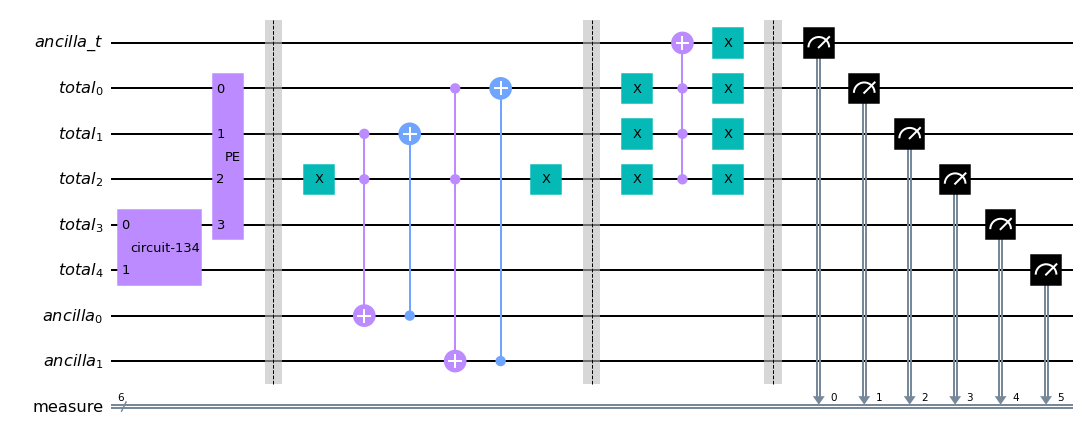

In [20]:
ancilla=2
ancilla_t=1
ancilla_reg_new=QuantumRegister(ancilla,'ancilla')
ancilla_reg_t_new=QuantumRegister(ancilla_t,'ancilla_t')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim_new = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(6, 'measure')

total_circuit_sim_new = QuantumCircuit(ancilla_reg_t_new,qr_total_sim_new,ancilla_reg_new,classical, name='matrix')

total_circuit_sim_new.append(matrix_circuit.to_gate(), qr_total_sim_new[resolution:])
total_circuit_sim_new.append(pe.to_gate(), qr_total_sim_new[0:pe.num_qubits])
total_circuit_sim_new.decompose(reps=1).draw("mpl")
total_circuit_sim_new.barrier()
total_circuit_sim_new.x(3)
total_circuit_sim_new.ccx(2,3,ancilla_reg_new[0])
total_circuit_sim_new.cx(ancilla_reg_new[0],2)

total_circuit_sim_new.ccx(1,3,ancilla_reg_new[1])
total_circuit_sim_new.cx(ancilla_reg_new[1],1)
total_circuit_sim_new.x(3)
total_circuit_sim_new.barrier()
for i in range(3):
    total_circuit_sim_new.x(i+1)
total_circuit_sim_new.mcx(control_qubits=[1,2,3],target_qubit=ancilla_reg_t_new)
for i in range(3):
    total_circuit_sim_new.x(i+1)
total_circuit_sim_new.x(ancilla_reg_t_new)
total_circuit_sim_new.barrier()
total_circuit_sim_new.measure([0,1,2,3,4,5],classical)
total_circuit_sim_new.draw('mpl')

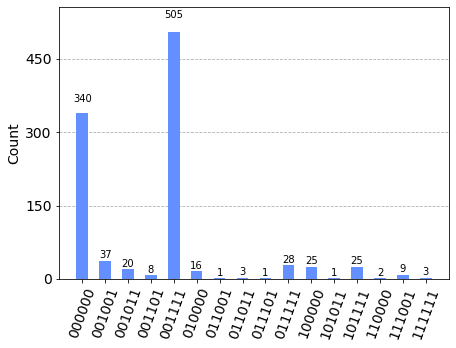

In [21]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim_new,aer)).result().get_counts()
plot_histogram(result)

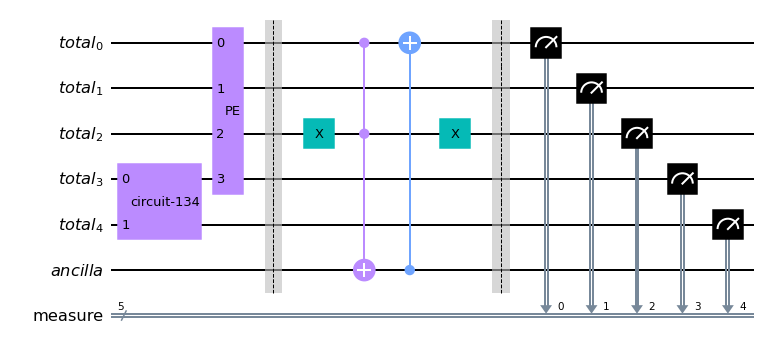

In [32]:
#Remove first cx
ancilla=1
ancilla_reg=QuantumRegister(ancilla,'ancilla')
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
classical = ClassicalRegister(5, 'measure')

total_circuit_sim2 = QuantumCircuit(qr_total_sim,ancilla_reg,classical, name='matrix')
display(total_circuit_sim)
total_circuit_sim2.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim2.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim2.decompose(reps=1).draw("mpl")
total_circuit_sim2.barrier()
total_circuit_sim2.x(2)
#total_circuit_sim2.ccx(1,2,ancilla_reg[0])
#§total_circuit_sim2.cx(ancilla_reg[0],1)

total_circuit_sim2.ccx(0,2,ancilla_reg)
total_circuit_sim2.cx(ancilla_reg,0)
total_circuit_sim2.x(2)
total_circuit_sim2.barrier()
total_circuit_sim2.measure([0,1,2,3,4],classical)
total_circuit_sim2.draw('mpl')

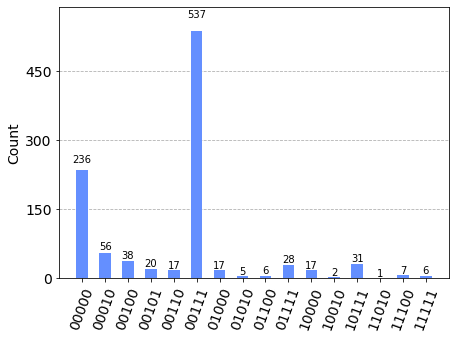

In [33]:
aer=Aer.get_backend('qasm_simulator')
result=aer.run(transpile(total_circuit_sim2,aer)).result().get_counts()
plot_histogram(result)

In [ ]:
#001,010,011-> taglia 011 ma non 010